# Visualization of Vanguard offerings

In [1]:
%matplotlib inline

from __future__ import division

import itertools
from collections import namedtuple

from lxml import etree

import pandas as pd

import matplotlib.pyplot as pl
import seaborn as sns
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
with open('etfs.html', 'r') as f:
    etfs_tree = etree.HTML(f.read())
    
with open('mutual_funds.html', 'r') as f:
    mutual_funds_tree = etree.HTML(f.read())

In [3]:
def parse_pcent(pcent_text):
    try:
        return float(pcent_text.rstrip('%')) / 100
    except Exception:
        return float('NaN')

Fund = namedtuple('Fund', 'name link expense_ratio avg_1_yr avg_5_yr avg_10_yr avg_annualized admiral')

etfs = etfs_tree.xpath('//tr')
mutual_funds = mutual_funds_tree.xpath('//tr')
funds = []
for i, row in enumerate(itertools.chain(etfs, mutual_funds)):
    if not row.xpath(".//td"):
        continue
        
    name, = row.xpath(".//div[contains(@class, 'productName')]//span/text()")
    link, = row.xpath(".//div[contains(@class, 'productName')]/a/@href")
    
    def numeric(xpath):
        raw, = row.xpath(xpath)
        return parse_pcent(raw)
    
    expense_ratio = numeric(".//td[contains(@class, 'expenseRatio')]/text()")
    avg_1_yr_annual_returns = numeric(".//td[contains(@data-ng-bind, 'oneYrPct')]/text()")
    avg_5_yr_annual_returns = numeric(".//td[contains(@data-ng-bind, 'fiveYrPct')]/text()")
    avg_10_yr_annual_returns = numeric(".//td[contains(@data-ng-bind, 'tenYrPct')]/text()")
    avg_annualized_returns = numeric(".//span[contains(@data-ng-bind, 'sinceInception')]/text()")
    
    funds.append(Fund(
        name=name,
        link=link,
        expense_ratio=expense_ratio,
        avg_1_yr=avg_1_yr_annual_returns,
        avg_5_yr=avg_5_yr_annual_returns,
        avg_10_yr=avg_10_yr_annual_returns,
        avg_annualized=avg_annualized_returns,
        admiral='admiral' in name.lower()
    ))

In [4]:
df = pd.DataFrame.from_records(funds, columns=Fund._fields)
df.describe()

,expense_ratio,avg_1_yr,avg_5_yr,avg_10_yr,avg_annualized,admiral
count,181.000000,181.000000,165.000000,127.000000,181.000000,181
mean,0.001687,0.108765,0.092260,0.051638,0.072834,0.2375691
std,0.001255,0.080249,0.058686,0.026784,0.036561,0.4267743
min,0.000400,-0.032600,-0.070300,-0.060400,0.001900,False
25%,0.000700,0.017300,0.038300,0.041550,0.049300,0
50%,0.001300,0.132300,0.099900,0.053300,0.069600,0
75%,0.002000,0.173800,0.146300,0.070650,0.091600,0
max,0.009000,0.334500,0.205400,0.107700,0.231200,True


In [5]:
class ClickInfo(plugins.PluginBase):

    JAVASCRIPT = """
    mpld3.register_plugin("clickinfo", ClickInfo);
    ClickInfo.prototype = Object.create(mpld3.Plugin.prototype);
    ClickInfo.prototype.constructor = ClickInfo;
    ClickInfo.prototype.requiredProps = ["id", "urls"];
    function ClickInfo(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    ClickInfo.prototype.draw = function(){
        var obj = mpld3.get_element(this.props.id);
        urls = this.props.urls;
        obj.elements().on("mousedown",
                          function(d, i){ 
                            window.open(urls[i], '_blank')});
    }
    """
    def __init__(self, points, urls):
        self.points = points
        self.urls = urls
        self.dict_ = {"type": "clickinfo",
                      "id": mpld3.utils.get_id(points, None),
                      "urls": urls}

In [6]:
def plot(x, y, title=None):
    fig, ax = pl.subplots(figsize=(12, 9))
    scatter = ax.scatter(x, y, s=60, c=['red' if admiral else 'blue' for admiral in df.admiral])
    span_template = """<span style='background:white'>{}</span>"""
    tooltip = plugins.PointHTMLTooltip(
        scatter, 
        labels=[span_template.format(name) for name in df.name],
        voffset=-20
    )
    url = ClickInfo(scatter, urls=list(df.link))
    pl.xlim([0, max(x * 1.05)])
    pl.ylim([-0.01, .35])
    pl.xlabel(x.name.replace('_', ' ').title())
    pl.ylabel(y.name.replace('_', ' ').title())
    if title:
        pl.title(title)
    plugins.connect(fig, tooltip)
    plugins.connect(fig, url)

## Graphs
Hover to view fund name, click to visit. Red coloring indicates an Admiral fund.

I:\Users\Chase Stevens\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


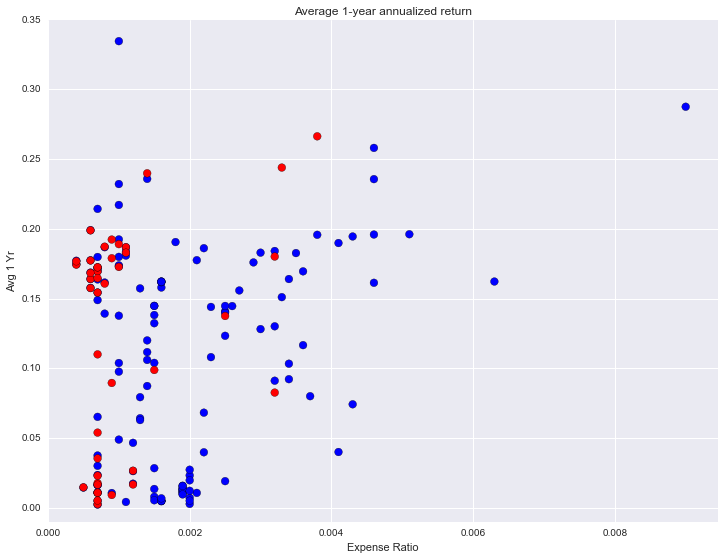

In [7]:
plot(x=df.expense_ratio, y=df.avg_1_yr, title='Average 1-year annualized return')

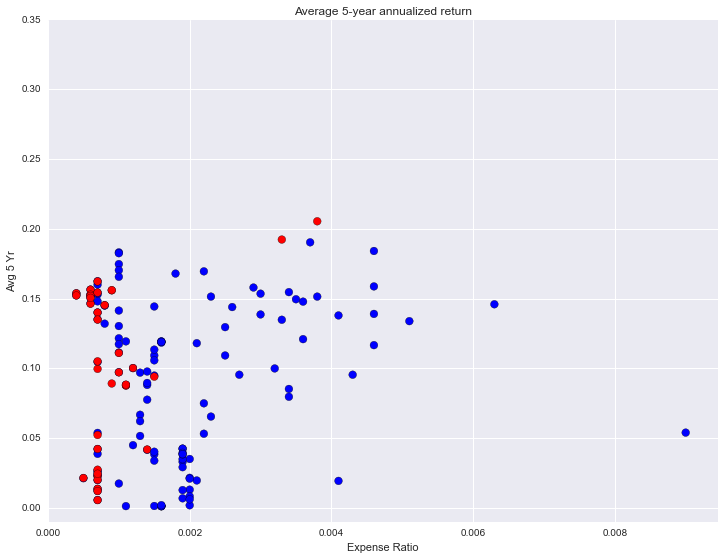

In [8]:
plot(x=df.expense_ratio, y=df.avg_5_yr, title='Average 5-year annualized return')

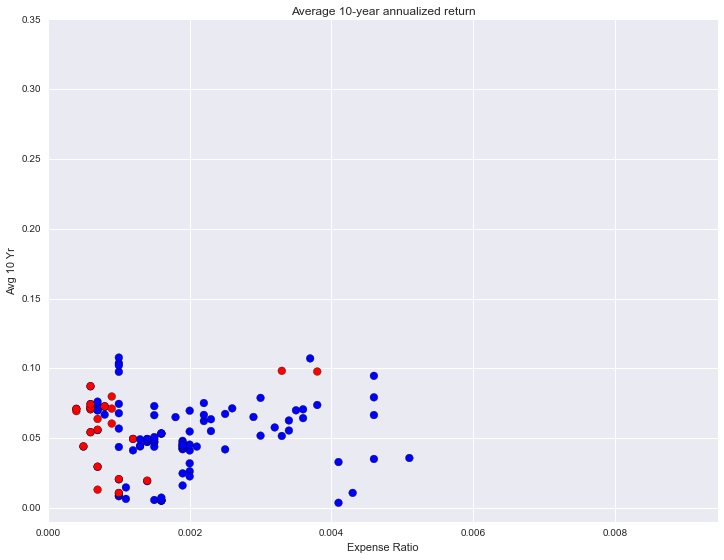

In [9]:
plot(x=df.expense_ratio, y=df.avg_10_yr, title='Average 10-year annualized return')

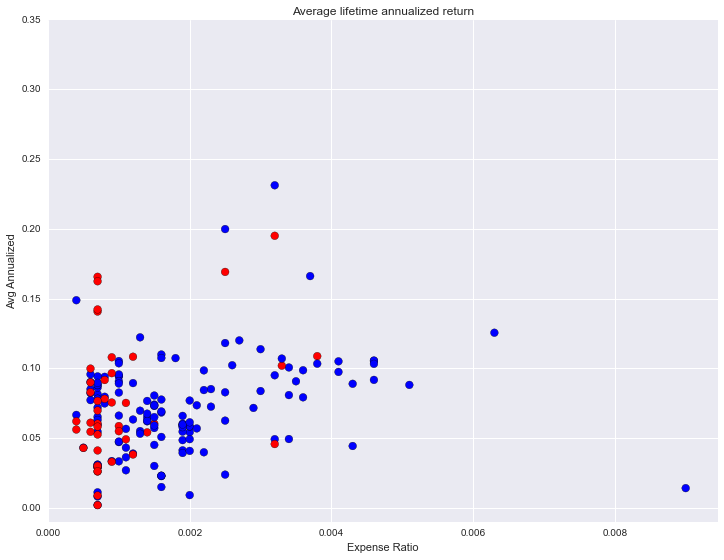

In [10]:
plot(x=df.expense_ratio, y=df.avg_annualized, title='Average lifetime annualized return')